In [ ]:

import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/missionfission/dragon-project 

In [31]:
# !pip install dragon-project/requirements.txt
# !pip install yamlordereddictloader
# !pip install transformers==4.0
# %cd dragon-project/src
%mkdir iters
%mkdir logs
# !ls
# !git clone https://github.com/facebookresearch/dlrm


In [2]:
%load_ext autoreload

%autoreload 2

import glob
import os
import sys
from collections import deque
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import yaml
import yamlordereddictloader

from torchvision import models
from yaml import dump
from scheduling import Scheduling
from generator import Generator, get_mem_props
from generator import *
from utils.visualizer import *
from ir.trace import trace
from ddfg_main import synthesis_hardware
from main import design_tech_runner, design_runner, run_single

Unable to import mlperf_logging,  No module named 'mlperf_logging'
Unable to import onnx.  No module named 'onnx'


In [3]:
from common_models import alexnet_graph, vggnet_graph, resnet_graph, bert_graph, gpt2_graph, dlrm_graph, alexnet_graph, langmodel_graph
# design_runner([vggnet_graph()])
# # for node in dlrm_graph.nodes:
# #     print(node.in_edge_mem + node.mem_fetch + node.out_edge_mem, node.compute_expense )

# design_tech_runner([dlrm_graph])
vgg11_graph = vggnet_graph()
resnet_graph_data = resnet_graph()
alexnet_data = alexnet_graph()
langmod_graph1, langmod_graph2 = langmodel_graph()
# dlrm_graph_data = dlrm_graph()
bert_graph_data = bert_graph()
gpt2_graph_data = gpt2_graph()
# 
# from nonai_models.graph_processing import graph_processing

I0212 18:10:00.371926 140229856749312 file_utils.py:39] PyTorch version 1.5.0 available.
/home/khushal/anaconda2/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Example 1 : Resnet-50  (Feedforward Neural Networks): Performance Estimation 


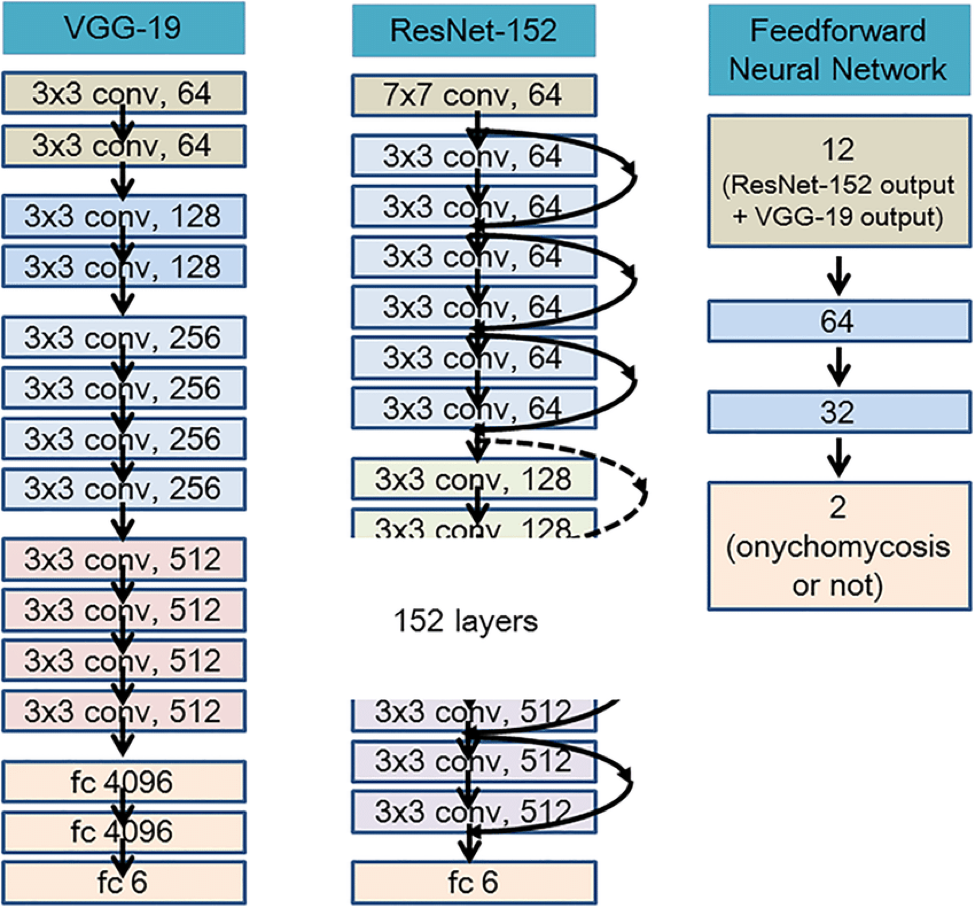


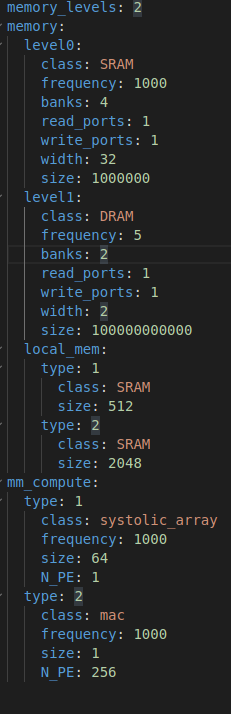

In [ ]:
run_single(resnet_graph_data, backprop=False, print_stats=True, filename = 'illusion_nvm.yaml', mapping="nn_dataflow")

## Example 2 : Non-AI Workloads : Architecture Synthesis and Performance Estimation 

In [8]:
import ast

from ir.staticfg.staticfg import CFGBuilder
cfg = CFGBuilder().build_from_file(
    "aes.py",
    "nonai_models/aes.py",
)
cfg.build_visual("aes", "pdf", show=True)
# print(cfg)

Subscript(value=Name(id='matrix', ctx=Load()), slice=Index(value=BinOp(left=Name(id='i', ctx=Load()), op=Div(), right=Num(n=4))), ctx=Load())
Subscript(value=Attribute(value=Name(id='self', ctx=Load()), attr='round_keys', ctx=Load()), slice=Index(value=Name(id='i', ctx=Load())), ctx=Load())
Subscript(value=Attribute(value=Name(id='self', ctx=Load()), attr='round_keys', ctx=Load()), slice=Index(value=Name(id='i', ctx=Load())), ctx=Load())
Subscript(value=Attribute(value=Name(id='self', ctx=Load()), attr='round_keys', ctx=Load()), slice=Index(value=Name(id='i', ctx=Load())), ctx=Load())


# AES : Advanced Encryption Standard

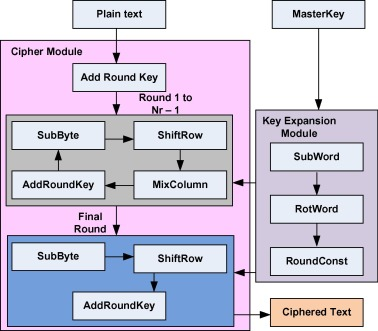


# Python Function

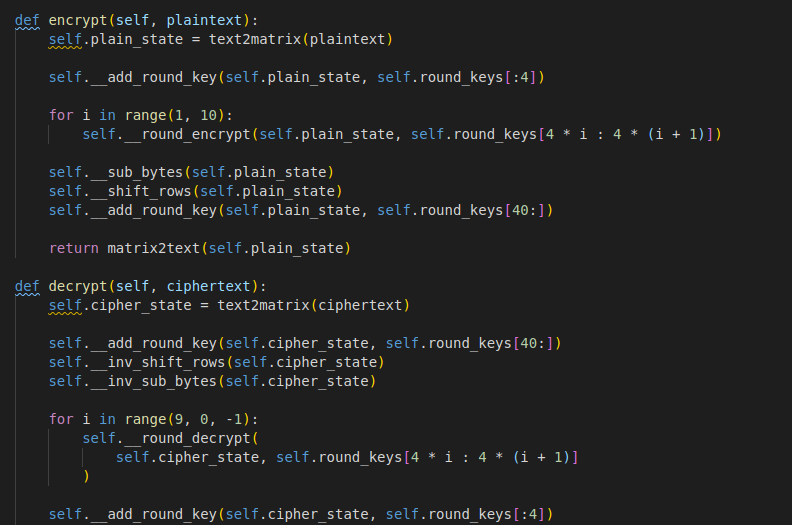


# AST (Abstract Syntax Tree) Generation

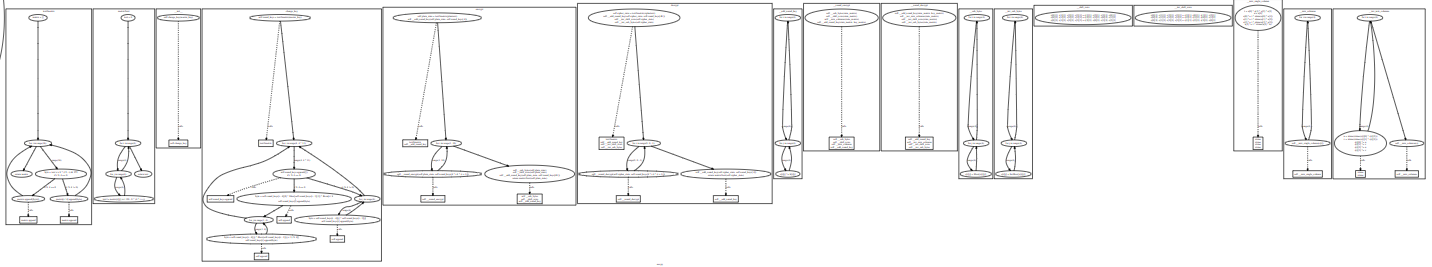

## Encrypt Function : AST

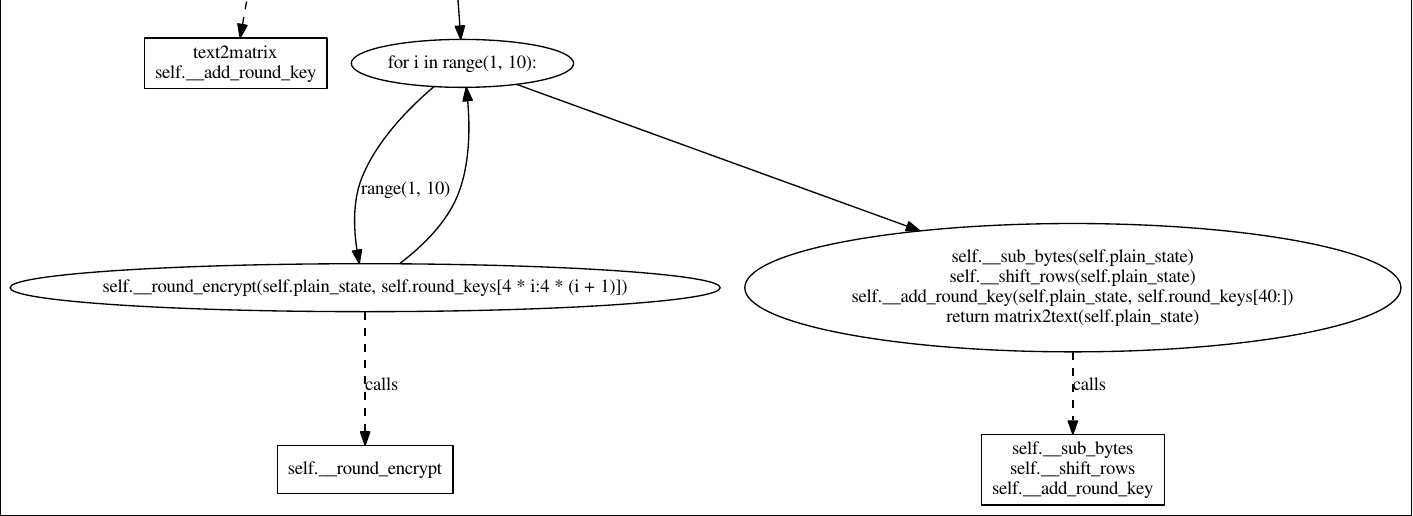

# Hardware Synthesis

In [7]:
synthesis_hardware("aes")

-------------------------------
aes,aes_aes/inputs/dynamic_trace.gz,aes_aes/test_aes.cfg,
-------------------------------
      Setting ScratchPad       
-------------------------------
-------------------------------
      Generating DDDG          
-------------------------------
-------------------------------1
-------------------------------2
-------------------------------
Num of Nodes: 14811
Num of Edges: 35693
Num of Reg Edges: 19191
Num of MEM Edges: 2132
Num of Control Edges: 14810
-------------------------------
-------------------------------
    Initializing BaseDatapath      
-------------------------------
 Top level: aes256_encrypt_ecb
      Optimizing...            aes
  Removing 9081 edges.
  Adding 6506 new edges.
  Removing 491 isolated nodes.
-------------------------------
        Mem to Reg Conv        
-------------------------------
-------------------------------
      ScratchPad Partition     
-------------------------------
cache_size 256
line_size 4
associati

# Graph Analytics : BFS

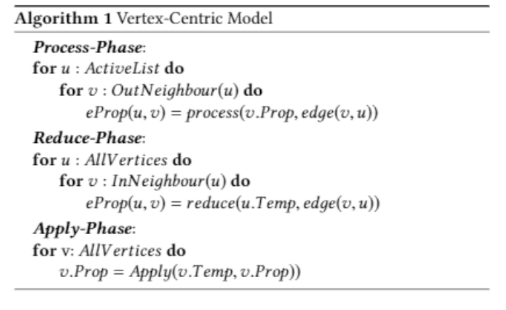

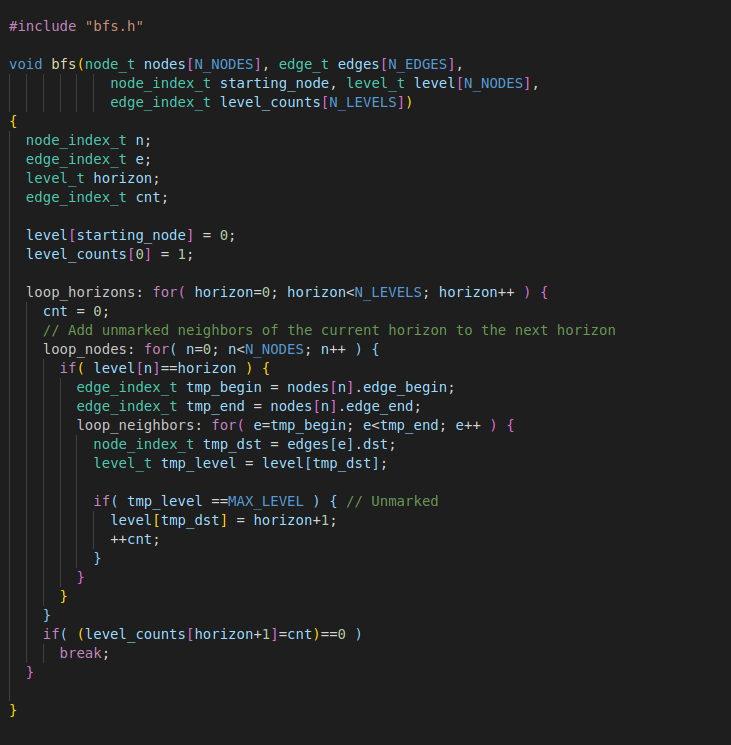


In [14]:
synthesis_hardware("aes")

-------------------------------
aes,aes_aes/inputs/dynamic_trace.gz,aes_aes/test_aes.cfg,
-------------------------------
      Setting ScratchPad       
-------------------------------
-------------------------------
      Generating DDDG          
-------------------------------
-------------------------------1
-------------------------------2
-------------------------------
Num of Nodes: 14811
Num of Edges: 35693
Num of Reg Edges: 19191
Num of MEM Edges: 2132
Num of Control Edges: 14810
-------------------------------
-------------------------------
    Initializing BaseDatapath      
-------------------------------
 Top level: aes256_encrypt_ecb
      Optimizing...            aes
  Removing 9081 edges.
  Adding 6506 new edges.
  Removing 491 isolated nodes.
-------------------------------
        Mem to Reg Conv        
-------------------------------
-------------------------------
      ScratchPad Partition     
-------------------------------
cache_size 256
line_size 4
associati

# Architecture Generation  : Google Bert

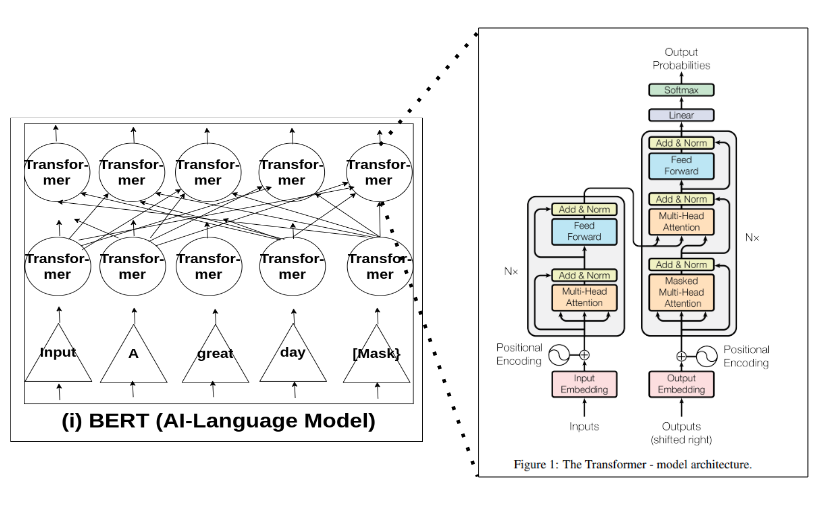

In [13]:
bert_graph_data

transformers.modeling_bert.BertModel (
	%input.1: long[1, 16],
	%1: float[30522, 768],
	%2: float[512, 768],
	%3: float[2, 768],
	%4: float[768],
	%5: float[768],
	%6: float[768, 768],
	%7: float[768],
	%8: float[768, 768],
	%9: float[768],
	%10: float[768, 768],
	%11: float[768],
	%12: float[768, 768],
	%13: float[768],
	%14: float[768],
	%15: float[768],
	%16: float[3072, 768],
	%17: float[3072],
	%18: float[768, 3072],
	%19: float[768],
	%20: float[768],
	%21: float[768],
	%22: float[768, 768],
	%23: float[768],
	%24: float[768, 768],
	%25: float[768],
	%26: float[768, 768],
	%27: float[768],
	%28: float[768, 768],
	%29: float[768],
	%30: float[768],
	%31: float[768],
	%32: float[3072, 768],
	%33: float[3072],
	%34: float[768, 3072],
	%35: float[768],
	%36: float[768],
	%37: float[768],
	%38: float[768, 768],
	%39: float[768],
	%40: float[768, 768],
	%41: float[768],
	%42: float[768, 768],
	%43: float[768],
	%44: float[768, 768],
	%45: float[768],
	%46: float[768],
	%47: float[768],

In [11]:
backprop = True
import time
start = time.time()
# name = ["vgg_graph", "resnet_graph","bert_graph","gpt2_graph", "dlrm_graph"]
# graph_list = [vgg11_graph, resnet_graph_data, bert_graph_data, gpt2_graph_data, dlrm_graph_data]
graph_list = [bert_graph_data]
name = ["bert_graph_data"]

for i,graph in enumerate(graph_list):
# for graph in [bert_graph_data]:
    log_file_name = "logs/"+str(name[i])+str(backprop)
    arch_time, arch_energy, arch_area = design_runner([graph], backprop, print_stats= False, stats_file = log_file_name)
# end = time.time()
# print(end-start)

======Optimizing Design=========
Faster :  6.300863118463623 Energy Improvement :  2.547587124233601 Area Budget :  0.6007853213621843


# 100X EDP : Technology Targets Generation (Google BERT)

In [3]:
generate_tech_targets([bert_graph_data], name = "BERT", EDP = 100)

For Benefit of EDP  100
Generating Technology Targets
Connectivity : 31x (T : 9.5, E : 2.3)
Logic Energy : 6x (T: 1.0, E: 2.1)
Logic Latency,  Connectivity : 2x (T: 1.9, E:1.1)


{}